## DNN-mk-II

Author: Justin Tan

Deep neural network. Do anything from MNIST to signal classification. With bells and whistles. Heavy modified from vanilla implementation.

June: Added cyclical annealing, parameter exponential moving average. Slight performance boost.

Update 26/06: Moved to GPU cluster.

July: Multi-GPU version

To-do: Model ensemble, benchmark, distributed training (*)

In [1]:
!nvidia-smi

Tue Jul  4 05:35:01 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 367.48                 Driver Version: 367.48                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 0000:05:00.0     Off |                    0 |
| N/A   45C    P0    60W / 149W |      0MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 0000:06:00.0     Off |                    0 |
| N/A   41C    P0    71W / 149W |      0MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import time, os

class config(object):
    # Set network parameters
    mode = 'kst'
    channel = 'rho0'
    keep_prob = 0.8
    num_epochs = 256
    batch_size = 512
    n_layers = 8
    hidden_layer_nodes = [1024, 1024, 1024, 512, 512, 512, 256, 256]
    learning_rate = 8e-6
    lr_epoch_decay = 0.99
    ema_decay = 0.999
    cycles = 4 # Number of annealing cycles
    n_classes = 2
    n_gpus = 4
    model = 'selu'

class directories(object):
    data = 'data'
    tensorboard = 'tensorboard'
    checkpoints = 'checkpoints'
    
architecture = '{} - {} | Layers: {} | Dropout: {} | Base LR: {} | Epochs: {}'.format(
    config.channel, config.mode, config.n_layers, config.keep_prob, config.learning_rate, config.num_epochs)

class reader():
    # Iterates over data and returns batches
    def __init__(self, df):
        
        self.df = df
        self.batch_size = config.batch_size
        self.steps_per_epoch = len(df) // config.batch_size
        self.epochs = 0
        self.proceed = True
        self.shuffle()

    def shuffle(self):
        self.df = self.df.sample(frac=1).reset_index(drop=True)
        self.df_X = self.df.drop('labels', axis = 1)
        self.df_y = self.df['labels']
        self.pointer = 0


    def next_batch(self, batch_size):
        if self.pointer + 1 >= self.steps_per_epoch:
            inputs = self.df_X.iloc[self.pointer*batch_size:]
            targets = self.df_y.iloc[self.pointer*batch_size:]
            self.epochs += 1
            self.shuffle()
            self.proceed = False
            
        inputs = self.df_X.iloc[self.pointer*batch_size:(self.pointer+1)*batch_size]
        targets = self.df_y.iloc[self.pointer*batch_size:(self.pointer+1)*batch_size]
        self.pointer += 1
                
        return inputs, targets

### Functions for graph construction

In [2]:
# SELU helper functions
import numbers
from tensorflow.contrib import layers
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.framework import tensor_util
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import random_ops
from tensorflow.python.ops import array_ops
from tensorflow.python.layers import utils

""" When using SELUs you have to keep the following in mind:
# (1) scale inputs to zero mean and unit variance
# (2) use SELUs
# (3) initialize weights with stddev sqrt(1/n)
# (4) use SELU dropout
"""
    
# (1) scale inputs to zero mean and unit variance

# (2) use SELUs
def selu(x):
    with ops.name_scope('elu') as scope:
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        return scale*tf.where(x>=0.0, x, alpha*tf.nn.elu(x))
    
# (3) initialize weights with stddev sqrt(1/n)
SELU_initializer = layers.variance_scaling_initializer(factor=1.0, mode='FAN_IN')

# (4) use this dropout
def dropout_selu(x, rate, alpha= -1.7580993408473766, fixedPointMean=0.0, fixedPointVar=1.0,
                 noise_shape=None, seed=None, name=None, training=False):
    """Dropout to a value with rescaling."""

    def dropout_selu_impl(x, rate, alpha, noise_shape, seed, name):
        keep_prob = 1.0 - rate
        x = ops.convert_to_tensor(x, name="x")
        if isinstance(keep_prob, numbers.Real) and not 0 < keep_prob <= 1:
            raise ValueError("keep_prob must be a scalar tensor or a float in the "
                                             "range (0, 1], got %g" % keep_prob)
        keep_prob = ops.convert_to_tensor(keep_prob, dtype=x.dtype, name="keep_prob")
        keep_prob.get_shape().assert_is_compatible_with(tensor_shape.scalar())

        alpha = ops.convert_to_tensor(alpha, dtype=x.dtype, name="alpha")
        alpha.get_shape().assert_is_compatible_with(tensor_shape.scalar())

        if tensor_util.constant_value(keep_prob) == 1:
            return x

        noise_shape = noise_shape if noise_shape is not None else array_ops.shape(x)
        random_tensor = keep_prob
        random_tensor += random_ops.random_uniform(noise_shape, seed=seed, dtype=x.dtype)
        binary_tensor = math_ops.floor(random_tensor)
        ret = x * binary_tensor + alpha * (1-binary_tensor)

        a = math_ops.sqrt(fixedPointVar / (keep_prob *((1-keep_prob) * math_ops.pow(alpha-fixedPointMean,2) + fixedPointVar)))

        b = fixedPointMean - a * (keep_prob * fixedPointMean + (1 - keep_prob) * alpha)
        ret = a * ret + b
        ret.set_shape(x.get_shape())
        return ret

    with ops.name_scope(name, "dropout", [x]) as name:
        return utils.smart_cond(training,
                                lambda: dropout_selu_impl(x, rate, alpha, noise_shape, seed, name),
                                lambda: array_ops.identity(x))

In [3]:
def load_data(file_name, test_size = 0.05):
    from sklearn.model_selection import train_test_split
    df = pd.read_hdf(file_name, 'df')
    df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df.drop('labels', axis = 1),
                                                                    df['labels'], test_size = test_size, random_state=42)
    return df_X_train, df_X_test, df_y_train, df_y_test

def save_summary(config, delta_t, train_acc, test_acc, test_auc):
    import json
    summary = {
        'Channel': config.channel,
        'Mode': config.mode,
        'Timestamp': time.strftime('%c'),
        'Model': config.model,
        'Layers': config.n_layers,
        'Batch_size': config.batch_size,
        'Dropout': config.keep_prob,
        'Epochs': config.num_epochs,
        'Time': delta_t,
        'Final train acc': train_acc,
        'Final test acc': test_acc,
        'Final test AUC': test_auc
    }
    # Writing JSON data
    if os.path.isfile('vdnn_summary.json'):
        with open('vdnn_summary.json.', 'r+') as f:
            new = json.load(f)
        new.append(summary)
        with open('vdnn_summary.json', 'w') as f:
            json.dump(new, f, indent = 4)
    else:
        with open('vdnn_summary.json', 'w') as f:
             json.dump([summary], f, indent = 4)

def layer_weights(shape, initializer = tf.contrib.layers.xavier_initializer()):
    # Return weight tensor of given shape using Xavier initialization
    W = tf.get_variable("weights", shape = shape, initializer=initializer)
    return W

def layer_biases(shape, init_value = 0.0):
    # Return bias tensor of given shape with small initialized constant value
    b = tf.get_variable("biases", shape = shape, initializer = tf.constant_initializer(init_value))
    return b
                

def hidden_layer_ops(x, shape, name, keep_prob, activation=tf.nn.relu):
    # Add operations to graph to construct hidden layers
    with tf.variable_scope(name) as scope:
        # scope.reuse_variables() # otherwise tf.get_variable() checks that already existing vars are not shared by accident
        weights = layer_weights(shape = shape)
        biases = layer_biases(shape = [shape[1]])
        
        # Apply non-linearity. Default is ReLU
        actv = activation(tf.matmul(x, weights) + biases)
        layer_output = tf.nn.dropout(actv, keep_prob)
        
    return layer_output

def hidden_SELU_ops(x, shape, name, keep_prob, phase = True):
    # Add operations to graph to construct hidden layers
    with tf.variable_scope(name) as scope:
        # scope.reuse_variables() # otherwise tf.get_variable() checks that already existing vars are not shared by accident
        weights = layer_weights(shape = shape, initializer = SELU_initializer)
        biases = layer_biases(shape = [shape[1]])
        
        # Apply non-linearity. Default is ReLU
        actv = selu(tf.add(tf.matmul(x, weights), biases))
        layer_output = dropout_selu(actv, rate = 1 - keep_prob, training = phase)
        
    return layer_output

def BN_layer_ops(x, shape, name, keep_prob, phase, activation=tf.nn.relu):
    # High-level implementation of BN
    with tf.variable_scope(name) as scope:
         # scope.reuse_variables() # otherwise tf.get_variable() checks that already existing vars are not shared by accident
        weights = layer_weights(shape = shape)
        biases = layer_biases(shape = [shape[1]])
        z_BN = tf.matmul(x, weights) + biases
        
        # Place BN transform before non-linearity - update to TF 1.2!
        theta_BN = tf.contrib.layers.batch_norm(z_BN, center=True, scale=True,is_training=phase, 
                                                decay=0.99, zero_debias_moving_mean=True, scope='bn', fused = True)
        BN_actv = activation(theta_BN)
        BN_layer_output = tf.nn.dropout(BN_actv, keep_prob)

    return BN_layer_output

def SELU_BN_layer_ops(x, shape, name, keep_prob, phase):
    # High-level implementation of BN
    with tf.variable_scope(name) as scope:
         # scope.reuse_variables() # otherwise tf.get_variable() checks that already existing vars are not shared by accident
        weights = layer_weights(shape = shape)
        biases = layer_biases(shape = [shape[1]])
        z_BN = tf.matmul(x, weights) + biases
        
        # Place BN transform before non-linearity - update to TF 1.2!
        theta_BN = tf.contrib.layers.batch_norm(z_BN, center=True, scale=True,is_training=phase, 
                                                decay=0.99, zero_debias_moving_mean=True, scope='bn', fused = True)
        BN_actv = selu(theta_BN)
        BN_layer_output = dropout_selu(BN_actv, rate = 1 - keep_prob, training = phase)

    return BN_layer_output

def readout_ops(x, shape, name, initializer = tf.contrib.layers.xavier_initializer()):
    # Don't apply non-linearity, dropout on output layer
    with tf.variable_scope(name) as scope:
        weights = layer_weights(shape = shape, initializer = initializer)
        biases = layer_biases(shape = [shape[1]])
        layer_output = tf.matmul(x, weights) + biases
        
    return layer_output

def build_network(x, n_layers, hidden_layer_nodes, keep_prob, training_phase):
    assert n_layers == len(hidden_layer_nodes), 'Specified layer nodes and number of layers do not correspond.'
    layers = [x]
    with tf.variable_scope('BN_layers') as scope:
        hidden_1 = BN_layer_ops(x, shape = [config.n_features, hidden_layer_nodes[0]], name = 'BNhidden0',
                                keep_prob = keep_prob, phase = training_phase)
        layers.append(hidden_1)
        for n in range(0,n_layers-1):
            hidden_n = BN_layer_ops(layers[-1], shape = [hidden_layer_nodes[n], hidden_layer_nodes[n+1]], name = 'BNhidden{}'.format(n+1),
                                   keep_prob = keep_prob, phase = training_phase)
            layers.append(hidden_n)
        readout = readout_ops(layers[-1], shape = [hidden_layer_nodes[-1], config.n_classes], name = 'readout')
        
    return readout

def network_builder(x, n_layers, hidden_layer_nodes, keep_prob, training_phase):
    assert n_layers == len(hidden_layer_nodes), 'Specified layer nodes and number of layers do not correspond.'
    layers = [x]
    if config.model == 'bn':
        print('Building ReLU + Batch-norm architecture')
        builder = BN_layer_ops
    elif config.model == 'selu':
        print('Building SELU architecture')
        builder = hidden_SELU_ops
    elif config.model == 'selu-bn':
        print('Building SELU + Batch-norm architecture')
        builder = SELU_BN_layer_ops
    else:
        print('Default architecture: SELU')
        builder = hidden_SELU_ops
        
    with tf.variable_scope('hidden_layers') as scope:
        hidden_1 = builder(x, shape = [config.n_features, hidden_layer_nodes[0]], name = 'hidden0',
                                keep_prob = keep_prob, phase = training_phase)
        layers.append(hidden_1)
        for n in range(0,n_layers-1):
            hidden_n = builder(layers[-1], shape = [hidden_layer_nodes[n], hidden_layer_nodes[n+1]], name = 'hidden{}'.format(n+1),
                                   keep_prob = keep_prob, phase = training_phase)
            layers.append(hidden_n)
        readout = readout_ops(layers[-1], shape = [hidden_layer_nodes[-1], config.n_classes], name = 'readout', initializer = SELU_initializer)
        
        return readout

def plot_ROC_curve(network_output, y_true, meta = ''):
#     import matplotlib as mpl
#     mpl.use('pgf')
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import roc_curve, auc
    y_score = network_output[:,1]
    
    # Compute ROC curve, integrate
    fpr, tpr, thresholds = roc_curve(y_true, y_score)    
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.axes([.1,.1,.8,.7])
    plt.figtext(.5,.9, r'$\mathrm{Receiver \;Operating \;Characteristic}$', fontsize=15, ha='center')
    plt.figtext(.5,.85, meta, fontsize=10,ha='center')
    plt.plot(fpr, tpr, color='darkorange',
                     lw=2, label='ROC (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=1.0, linestyle='--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel(r'$\mathrm{False \;Positive \;Rate}$')
    plt.ylabel(r'$\mathrm{True \;Positive \;Rate}$')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join('graphs', '{}_{}_ROC.pdf'.format(config.channel, config.mode)), format='pdf', dpi=1000)
    #plt.savefig(os.path.join('graphs', '{}_{}_ROC.pgf'.format(config.channel, config.mode)), format='pgf', dpi=1000)
    print('AUC: {:g}'.format(roc_auc))
    plt.show()
    plt.gcf().clear()
    return roc_auc
    
def cosine_anneal(initial_lr, t, T, M):
    from math import ceil
    beta = initial_lr/2 * (np.cos(np.pi* (t % ceil(T/M))/ceil(T/M)) + 1)
    return beta

def tower_computation(scope, inputs, labels, keep_prob, training_phase, n_gpu):
    """ Calculate the total loss on a single computation tower.
    Args:
        scope: unique prefix string identifying the tower, e.g. 'tower_0'
        inputs: 2D tensor of shape [batch_size, n_features]
        labels: 1D tensor of shape [batch_size]
    Returns:
        cross_entropy: Tensor containing the total loss for a batch of data
        readout: logits of readout layer
    """
    # Build inference graph
    readout = network_builder(inputs, config.n_layers, config.hidden_layer_nodes, keep_prob, training_phase)
    # Get losses - try L2 loss?
    cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = readout, labels = labels))
    tf.add_to_collection('losses_collection', cross_entropy)
    
    # Assemble all of the losses for the current tower only.
    losses = tf.get_collection('losses_collection', scope)
    
    # Compute the moving average of all individual losses and the total loss.
#     loss_averages = tf.train.ExponentialMovingAverage(0.9, name='avg')
#     loss_averages_op = loss_averages.apply(losses)

    for l in losses:
        tf.summary.scalar('xentropy_{}-raw'.format(n_gpu), l)
        #tf.summary.scalar('xentropy_{}'.format(n_gpu), loss_averages.average(l))
        
    return cross_entropy, readout

def average_gradients(tower_grads):
    """ Calculate the average gradient for each shared variable across all towers.
    Args:
    tower_grads: Nested list of (gradient, variable) tuples. The outer list
      is over individual gradients. The inner list is over the gradient
      calculation for each tower.
    Returns:
     List of pairs of (gradient, variable) where the gradient has been averaged
     across all towers.
    """
    average_grads = []
    for grad_var_pair in zip(*tower_grads):
        # Note that each grad_and_vars looks like the following:
        #   ((grad0_gpu0, var0_gpu0), ... , (grad0_gpuN, var0_gpuN))
        grads = []
        for g, _ in grad_var_pair:
            # Add 0 dimension to the gradients to represent the tower.
            expanded_g = tf.expand_dims(g, 0)
            # Append on a 'tower' dimension which we will average over below.
            grads.append(expanded_g)
        # Average over the 'tower' dimension.
        grad = tf.concat(axis=0, values=grads)
        grad = tf.reduce_mean(grad, 0)

        # Keep in mind that the Variables are redundant because they are shared
        # across towers. So just return the first tower's pointer to
        # the Variable.
        v = grad_var_pair[0][1]
        gv_pair = (grad, v)
        average_grads.append(gv_pair)
        
    return average_grads

In [4]:
test_file = '/data/projects/punim0011/jtan/data/dnn/norm_std_dnn_B02rho0gamma_kst.h5'
assert config.batch_size % config.n_gpus == 0, 'Batch size must be divisible by number of GPUs'
assert config.n_layers == len(config.hidden_layer_nodes), 'Inconsistent number of hidden layers'

df_X_train, df_X_test, df_y_train, df_y_test = load_data(test_file)
df_y_train = df_y_train.astype(np.int8)
df_y_test = df_y_test.astype(np.int8)
df_train = pd.concat([df_X_train, df_y_train], axis = 1)
df_test = pd.concat([df_X_test, df_y_test], axis = 1)
config.n_features = df_train.shape[1]-1
config.steps_per_epoch = df_train.shape[0] // config.batch_size
config.T = config.steps_per_epoch*config.num_epochs

readerTrain = reader(df_train)
readerTest = reader(df_test)

In [5]:
class vanillaDNN():
    # Builds the computational graph
    def __init__(self, config, training = True):
        self.x = tf.placeholder(tf.float32, shape = [None, config.n_features])
        self.y_true = tf.placeholder(tf.int32, shape = None)
        self.keep_prob = tf.placeholder(tf.float32)
        self.training_phase = tf.placeholder(tf.bool)
        self.beta = tf.placeholder(tf.float32)
        self.global_step = tf.get_variable('global_step', [], initializer=tf.constant_initializer(0), trainable=False)
        beta = tf.train.exponential_decay(config.learning_rate, self.global_step, 
                                          decay_steps = config.steps_per_epoch, decay_rate = config.lr_epoch_decay, staircase=True)

        input_batches = tf.split(self.x, config.n_gpus, axis = 0)
        label_batches = tf.split(self.y_true, config.n_gpus, axis = 0)
        opt = tf.train.AdamOptimizer(config.learning_rate)

        # Calculate gradients for each model tower
        tower_grads, tower_readouts, tower_losses, tower_summaries = [], [], [], []
        for gpu in range(config.n_gpus):
            with tf.device('/gpu:{}'.format(gpu)):
                with tf.variable_scope('vDNN', reuse=(gpu > 0)):
                    with tf.name_scope('tower_{}'.format(gpu)) as scope:
                        # Load one batch per GPU
                        input_batch, label_batch = input_batches[gpu], label_batches[gpu]

                        # Calculate loss for one tower of the model. Construct the entire model,
                        # but share the variable across all towers
                        loss, readout = tower_computation(scope, input_batch, label_batch, self.keep_prob, self.training_phase, gpu)
                        # Reuse variables for the next tower, retain the summaries from the final tower.
                        #tf.get_variable_scope().reuse_variables()
                        summaries = tf.get_collection(tf.GraphKeys.SUMMARIES, scope)

                        # Retain batch norm update operations only from the final tower.
                        # batchnorm_updates = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope)

                        # Calculate the gradients for given batch on this tower
                        grads = opt.compute_gradients(loss)
                        tower_grads.append(grads)
                        tower_readouts.append(readout)
                        tower_summaries.append(summaries)
                        tower_losses.append(loss)

        # Synchronize all towers
        mean_grads = average_gradients(tower_grads)
        self.readout = tf.concat(tower_readouts, axis = 0)

        # Evaluation metrics
        self.cross_entropy = tf.reduce_mean(tower_losses)
        self.prediction = tf.nn.softmax(self.readout)
        correct_prediction = tf.equal(tf.cast(tf.argmax(self.readout, 1), tf.int32), self.y_true)
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        _, self.auc_op = tf.metrics.auc(predictions = tf.argmax(self.readout,1), labels = self.y_true, num_thresholds = 512)

        # Track moving average of trainable variables
        self.ema = tf.train.ExponentialMovingAverage(decay = config.ema_decay, num_updates = self.global_step)
        maintain_averages_op = self.ema.apply(tf.trainable_variables())

        # Apply the gradients to adjust the shared variables.
        apply_gradient_op = opt.apply_gradients(mean_grads, global_step=self.global_step)

        # Group all updates to into a single train op.
        #batchnorm_updates_op = tf.group(*batchnorm_updates)
        self.train_op = tf.group(apply_gradient_op, maintain_averages_op)#, batchnorm_updates_op)

        saver = tf.train.Saver(tf.global_variables())

        # Build the summary operation from the last tower summaries
        tower_summaries.append(tf.summary.scalar('cross_entropy', self.cross_entropy))
        tower_summaries.append(tf.summary.scalar('accuracy', self.accuracy))
        tower_summaries.append(tf.summary.scalar('auc', self.auc_op))
        tower_summaries.append(tf.summary.scalar('global_step', self.global_step))
        tower_summaries.append(tf.summary.scalar('learning_rate', beta))
        self.merge_op = tf.summary.merge(tower_summaries)
        self.train_writer = tf.summary.FileWriter(
            os.path.join(directories.tensorboard, 'train_{}'.format(time.strftime('%d-%m_%I:%M'))), graph = tf.get_default_graph())
        self.test_writer = tf.summary.FileWriter(
            os.path.join(directories.tensorboard, 'test_{}'.format(time.strftime('%d-%m_%I:%M'))))
    
    # Make predictions
    def predict(self, ckpt, metaGraph = None):
        pin_cpu = tf.ConfigProto(allow_soft_placement=True, log_device_placement=True, device_count = {'GPU':0})
    
        # Restore the moving average version of the learned variables for eval.
        #variable_averages = tf.train.ExponentialMovingAverage(config.ema_decay)
        variables_to_restore = self.ema.variables_to_restore()
        #variables_to_restore = variable_averages.variables_to_restore()
        saver = tf.train.Saver(variables_to_restore)
        
        with tf.Session(config=pin_cpu) as sess:
            # Initialize variables
            init_op = tf.global_variables_initializer()
            sess.run(init_op)
            sess.run(tf.local_variables_initializer())

            start_time = time.time()
            
            assert (ckpt.model_checkpoint_path or metaGraph), 'Missing checkpoint file!'
            
            if metaGraph:
                saver = tf.train.import_meta_graph(metaGraph)
                saver.restore(sess, os.path.splitext(metaGraph)[0])
                print('{} restored.'.format(metaGraph))
            else:    
                saver.restore(sess, ckpt.model_checkpoint_path)
                print('{} restored.'.format(ckpt.model_checkpoint_path))

            # Make predictions using the trained model
            feed_dict_test = {self.x: df_X_test.values, self.y_true: df_y_test.values, self.keep_prob: 1.0, self.training_phase: False}
            network_output_test, final_v_acc, final_v_auc = sess.run(
                [self.prediction, self.accuracy, self.auc_op], feed_dict = feed_dict_test)

            print("Validation accuracy: {:g}\nValidation AUC: {:g}".format(final_v_acc, final_v_auc))
            
            plot_ROC_curve(network_output = network_output_test, y_true = df_y_test.values,
                           meta = architecture + ' | Test accuracy: {}'.format(final_v_acc))
            delta_t = time.time() - start_time
            print("Inference complete. Duration: %g s" %(delta_t))
            
            return network_output_test

In [ ]:
def train(config, restore = False):
    # Executes training operations
    vDNN = vanillaDNN(config, training = True)
    start_time = time.time()
    v_acc_best = 0.
    global_step = 0
    global_epoch = 0
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(directories.checkpoints)

    with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:
        # Initialize variables
        init_op = tf.global_variables_initializer()
        sess.run(init_op)
        
        if restore and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)
            global_epoch = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
            assert (type(global_epoch) == int), 'Epoch number untracked'
            print('{} restored at epoch {}.'.format(ckpt.model_checkpoint_path, global_epoch))              
            
        for epoch in range(global_epoch,config.num_epochs):
            
            readerTrain.proceed = True
            step = 0
            # Save every 10 epochs    
            if epoch % 10 == 0:
                save_path = saver.save(sess,
                                       os.path.join(directories.checkpoints,
                                                    'vDNN_{}_{}_epoch{}.ckpt'.format(config.mode, config.channel, epoch)),
                                       global_step = epoch)
                print('Graph saved to file: {}'.format(save_path))
                
            print('(*) Entering Epoch {} ({:.3f} s)'.format(epoch, time.time() - start_time))
            
            while(readerTrain.proceed):
                # Iterate through entire corpus
                x_train, y_train = readerTrain.next_batch(config.batch_size)
                beta = cosine_anneal(config.learning_rate, global_step, config.T, config.cycles)
                feed_dict_train = {vDNN.x: x_train.values, vDNN.y_true: y_train.values, 
                                   vDNN.keep_prob: config.keep_prob, vDNN.training_phase: True, vDNN.beta: beta}
                t_op = sess.run(vDNN.train_op, feed_dict = feed_dict_train)
                step += 1
                global_step += 1

                if step % (config.steps_per_epoch // 5) == 0:            
                    # Evaluate model
                    improved = ''
                    sess.run(tf.local_variables_initializer())
                    x_test, y_test = readerTest.next_batch(config.batch_size)
                    feed_dict_test = {vDNN.x: x_test.values, vDNN.y_true: y_test.values, vDNN.keep_prob: 1.0,
                                      vDNN.training_phase: False, vDNN.beta: 0}

                    t_acc, t_summary = sess.run([vDNN.accuracy, vDNN.merge_op],
                                                        feed_dict = feed_dict_train)
                    v_acc, v_loss, v_auc, v_summary, = sess.run([vDNN.accuracy, vDNN.cross_entropy, vDNN.auc_op, vDNN.merge_op],
                                                        feed_dict = feed_dict_test)

                    vDNN.train_writer.add_summary(t_summary, step)
                    vDNN.test_writer.add_summary(v_summary, step)
                    
                    if epoch > 8 and v_acc > v_acc_best:
                        v_acc_best = v_acc
                        improved = '[*]'
                        save_path = saver.save(sess, 
                                               os.path.join(directories.checkpoints,
                                                            'vDNN_{}_{}_best.ckpt'.format(config.mode, config.channel)),
                                               global_step = epoch)
                    
                    print('Epoch {}, Step {} | Training Acc: {:.3f} | Test Acc: {:.3f} | Test Loss: {:.3f} | Test AUC {:.3f} ({:.2f} s) {}'
                          .format(epoch, step, t_acc, v_acc, v_loss, v_auc, time.time() - start_time, improved))

        save_path = saver.save(sess, os.path.join(directories.checkpoints, 'vDNN_{}_{}_end.ckpt'.format(config.mode, config.channel)),
                               global_step = epoch)
        print('Model saved to file: {}'.format(save_path))

# #         end = int(config.n_gpus*round(df_X_train.shape[0]/config.n_gpus))
# #         feed_dict_train = {vDNN.x: df_X_train.iloc[:end].values, vDNN.y_true: df_y_train.iloc[:end].values, vDNN.keep_prob: 1.0, vDNN.training_phase: False}
# #         feed_dict_test = {vDNN.x: df_X_test.iloc[:end].values, vDNN.y_true: df_y_test.iloc[:end].values, vDNN.keep_prob: 1.0, vDNN.training_phase: False}
# #         final_t_acc = vDNN.accuracy.eval(feed_dict = feed_dict_train)
# #         final_v_acc, final_v_AUC = sess.run([vDNN.accuracy, vDNN.auc_op], feed_dict = feed_dict_test
#     print("Train accuracy: {:g}\nValidation accuracy: {:g}\nValidation AUC: {:g}".format(final_t_acc, final_v_acc, final_v_AUC))
#     save_summary(config, delta_t, final_t_acc, final_v_acc, final_v_AUC)

    delta_t = time.time() - start_time        
    print("Training Complete. Time elapsed: {:.3f} s".format(delta_t))
    print('Architecture: {}'.format(architecture))

In [ ]:
train(config)

Building SELU architecture
Building SELU architecture
Building SELU architecture
Building SELU architecture
Graph saved to file: checkpoints/vDNN_kst_rho0_epoch0.ckpt-0
(*) Entering Epoch 0 (11.952 s)
Epoch 0, Step 190 | Training Acc: 0.533 | Test Acc: 0.666 | Test Loss: 1.269 | Test AUC 0.612 (16.95 s) 
Epoch 0, Step 380 | Training Acc: 0.633 | Test Acc: 0.682 | Test Loss: 2.177 | Test AUC 0.667 (20.67 s) 
Epoch 0, Step 570 | Training Acc: 0.678 | Test Acc: 0.771 | Test Loss: 1.816 | Test AUC 0.730 (24.39 s) 
Epoch 0, Step 760 | Training Acc: 0.697 | Test Acc: 0.773 | Test Loss: 2.182 | Test AUC 0.738 (28.09 s) 
Epoch 0, Step 950 | Training Acc: 0.727 | Test Acc: 0.750 | Test Loss: 2.191 | Test AUC 0.741 (32.75 s) 
(*) Entering Epoch 1 (32.754 s)
Epoch 1, Step 190 | Training Acc: 0.742 | Test Acc: 0.744 | Test Loss: 2.095 | Test AUC 0.747 (36.45 s) 
Epoch 1, Step 380 | Training Acc: 0.699 | Test Acc: 0.764 | Test Loss: 1.925 | Test AUC 0.728 (40.20 s) 
Epoch 1, Step 570 | Training Acc

Epoch 17, Step 380 | Training Acc: 0.805 | Test Acc: 0.836 | Test Loss: 1.337 | Test AUC 0.809 (350.16 s) 
Epoch 17, Step 570 | Training Acc: 0.816 | Test Acc: 0.822 | Test Loss: 1.265 | Test AUC 0.804 (353.85 s) 
Epoch 17, Step 760 | Training Acc: 0.842 | Test Acc: 0.855 | Test Loss: 0.867 | Test AUC 0.835 (357.53 s) 
(*) Entering Epoch 18 (361.964 s)
Epoch 18, Step 190 | Training Acc: 0.816 | Test Acc: 0.816 | Test Loss: 1.334 | Test AUC 0.807 (365.65 s) 
Epoch 18, Step 380 | Training Acc: 0.828 | Test Acc: 0.809 | Test Loss: 1.493 | Test AUC 0.800 (369.33 s) 
Epoch 18, Step 570 | Training Acc: 0.857 | Test Acc: 0.863 | Test Loss: 1.049 | Test AUC 0.849 (373.03 s) 
Epoch 18, Step 760 | Training Acc: 0.795 | Test Acc: 0.822 | Test Loss: 1.543 | Test AUC 0.789 (376.70 s) 
(*) Entering Epoch 19 (381.157 s)
Epoch 19, Step 190 | Training Acc: 0.801 | Test Acc: 0.840 | Test Loss: 1.118 | Test AUC 0.807 (384.88 s) 
Epoch 19, Step 380 | Training Acc: 0.832 | Test Acc: 0.838 | Test Loss: 1.29

Epoch 34, Step 760 | Training Acc: 0.844 | Test Acc: 0.824 | Test Loss: 1.110 | Test AUC 0.831 (685.41 s) 
(*) Entering Epoch 35 (689.836 s)
Epoch 35, Step 190 | Training Acc: 0.828 | Test Acc: 0.820 | Test Loss: 1.154 | Test AUC 0.818 (693.57 s) 
Epoch 35, Step 380 | Training Acc: 0.852 | Test Acc: 0.838 | Test Loss: 0.814 | Test AUC 0.842 (697.25 s) 
Epoch 35, Step 570 | Training Acc: 0.850 | Test Acc: 0.834 | Test Loss: 1.067 | Test AUC 0.842 (700.95 s) 
Epoch 35, Step 760 | Training Acc: 0.838 | Test Acc: 0.811 | Test Loss: 1.030 | Test AUC 0.819 (704.60 s) 
(*) Entering Epoch 36 (709.032 s)
Epoch 36, Step 190 | Training Acc: 0.842 | Test Acc: 0.854 | Test Loss: 0.982 | Test AUC 0.842 (712.75 s) 
Epoch 36, Step 380 | Training Acc: 0.869 | Test Acc: 0.871 | Test Loss: 0.841 | Test AUC 0.863 (716.45 s) 
Epoch 36, Step 570 | Training Acc: 0.865 | Test Acc: 0.824 | Test Loss: 1.000 | Test AUC 0.840 (720.21 s) 
Epoch 36, Step 760 | Training Acc: 0.861 | Test Acc: 0.855 | Test Loss: 1.16

Epoch 52, Step 380 | Training Acc: 0.857 | Test Acc: 0.832 | Test Loss: 1.104 | Test AUC 0.843 (1026.02 s) 
Epoch 52, Step 570 | Training Acc: 0.846 | Test Acc: 0.822 | Test Loss: 1.056 | Test AUC 0.831 (1029.74 s) 
Epoch 52, Step 760 | Training Acc: 0.836 | Test Acc: 0.830 | Test Loss: 1.023 | Test AUC 0.831 (1033.42 s) 
(*) Entering Epoch 53 (1037.880 s)
Epoch 53, Step 190 | Training Acc: 0.857 | Test Acc: 0.791 | Test Loss: 1.128 | Test AUC 0.822 (1041.56 s) 
Epoch 53, Step 380 | Training Acc: 0.854 | Test Acc: 0.836 | Test Loss: 1.058 | Test AUC 0.840 (1045.26 s) 
Epoch 53, Step 570 | Training Acc: 0.871 | Test Acc: 0.844 | Test Loss: 0.913 | Test AUC 0.855 (1048.95 s) 
Epoch 53, Step 760 | Training Acc: 0.854 | Test Acc: 0.822 | Test Loss: 1.223 | Test AUC 0.834 (1052.60 s) 
(*) Entering Epoch 54 (1057.039 s)
Epoch 54, Step 190 | Training Acc: 0.869 | Test Acc: 0.852 | Test Loss: 0.776 | Test AUC 0.861 (1060.76 s) 
Epoch 54, Step 380 | Training Acc: 0.855 | Test Acc: 0.844 | Test 

In [6]:
train(config)

Graph saved to file: checkpoints/vDNN_kst_rho0_epoch0.ckpt-0
(*) Entering Epoch 0 (13.018 s)
Epoch 0, Step 190 | Training Acc: 0.830 | Test Acc: 0.676 | Test Loss: 0.965 | Test AUC 0.771 (22.18 s) 
Epoch 0, Step 380 | Training Acc: 0.812 | Test Acc: 0.816 | Test Loss: 0.483 | Test AUC 0.815 (29.07 s) 
Epoch 0, Step 570 | Training Acc: 0.818 | Test Acc: 0.814 | Test Loss: 0.453 | Test AUC 0.818 (35.93 s) 
Epoch 0, Step 760 | Training Acc: 0.838 | Test Acc: 0.828 | Test Loss: 0.376 | Test AUC 0.828 (42.77 s) 
Epoch 0, Step 950 | Training Acc: 0.873 | Test Acc: 0.865 | Test Loss: 0.325 | Test AUC 0.868 (50.58 s) 
(*) Entering Epoch 1 (50.583 s)
Epoch 1, Step 190 | Training Acc: 0.850 | Test Acc: 0.865 | Test Loss: 0.341 | Test AUC 0.849 (57.42 s) 
Epoch 1, Step 380 | Training Acc: 0.863 | Test Acc: 0.830 | Test Loss: 0.374 | Test AUC 0.834 (64.25 s) 
Epoch 1, Step 570 | Training Acc: 0.861 | Test Acc: 0.883 | Test Loss: 0.325 | Test AUC 0.863 (71.08 s) 
Epoch 1, Step 760 | Training Acc: 0

Epoch 17, Step 570 | Training Acc: 0.869 | Test Acc: 0.883 | Test Loss: 0.291 | Test AUC 0.869 (627.63 s) 
Epoch 17, Step 760 | Training Acc: 0.889 | Test Acc: 0.805 | Test Loss: 0.465 | Test AUC 0.818 (634.41 s) 
(*) Entering Epoch 18 (641.769 s)
Epoch 18, Step 190 | Training Acc: 0.895 | Test Acc: 0.816 | Test Loss: 0.430 | Test AUC 0.820 (648.51 s) 
Epoch 18, Step 380 | Training Acc: 0.896 | Test Acc: 0.883 | Test Loss: 0.304 | Test AUC 0.874 (655.26 s) 
Epoch 18, Step 570 | Training Acc: 0.895 | Test Acc: 0.865 | Test Loss: 0.304 | Test AUC 0.871 (661.99 s) 
Epoch 18, Step 760 | Training Acc: 0.852 | Test Acc: 0.873 | Test Loss: 0.285 | Test AUC 0.852 (668.71 s) 
(*) Entering Epoch 19 (676.046 s)
Epoch 19, Step 190 | Training Acc: 0.908 | Test Acc: 0.811 | Test Loss: 0.405 | Test AUC 0.835 (682.78 s) 
Epoch 19, Step 380 | Training Acc: 0.898 | Test Acc: 0.881 | Test Loss: 0.294 | Test AUC 0.881 (689.51 s) 
Epoch 19, Step 570 | Training Acc: 0.895 | Test Acc: 0.893 | Test Loss: 0.25

(*) Entering Epoch 35 (1227.974 s)
Epoch 35, Step 190 | Training Acc: 0.906 | Test Acc: 0.887 | Test Loss: 0.296 | Test AUC 0.889 (1234.71 s) 
Epoch 35, Step 380 | Training Acc: 0.902 | Test Acc: 0.902 | Test Loss: 0.243 | Test AUC 0.896 (1241.46 s) 
Epoch 35, Step 570 | Training Acc: 0.910 | Test Acc: 0.820 | Test Loss: 0.416 | Test AUC 0.849 (1248.19 s) 
Epoch 35, Step 760 | Training Acc: 0.908 | Test Acc: 0.879 | Test Loss: 0.304 | Test AUC 0.882 (1254.92 s) 
(*) Entering Epoch 36 (1262.254 s)
Epoch 36, Step 190 | Training Acc: 0.900 | Test Acc: 0.881 | Test Loss: 0.271 | Test AUC 0.886 (1269.00 s) 
Epoch 36, Step 380 | Training Acc: 0.904 | Test Acc: 0.908 | Test Loss: 0.232 | Test AUC 0.898 (1275.75 s) 
Epoch 36, Step 570 | Training Acc: 0.910 | Test Acc: 0.893 | Test Loss: 0.302 | Test AUC 0.893 (1282.55 s) 
Epoch 36, Step 760 | Training Acc: 0.885 | Test Acc: 0.879 | Test Loss: 0.313 | Test AUC 0.874 (1289.27 s) 
(*) Entering Epoch 37 (1296.624 s)
Epoch 37, Step 190 | Training A

Epoch 52, Step 380 | Training Acc: 0.918 | Test Acc: 0.770 | Test Loss: 0.613 | Test AUC 0.800 (1827.17 s) 
Epoch 52, Step 570 | Training Acc: 0.926 | Test Acc: 0.795 | Test Loss: 0.451 | Test AUC 0.844 (1833.92 s) 
Epoch 52, Step 760 | Training Acc: 0.912 | Test Acc: 0.820 | Test Loss: 0.460 | Test AUC 0.848 (1840.67 s) 
(*) Entering Epoch 53 (1847.992 s)
Epoch 53, Step 190 | Training Acc: 0.926 | Test Acc: 0.871 | Test Loss: 0.314 | Test AUC 0.887 (1854.71 s) 
Epoch 53, Step 380 | Training Acc: 0.918 | Test Acc: 0.902 | Test Loss: 0.270 | Test AUC 0.900 (1861.45 s) 
Epoch 53, Step 570 | Training Acc: 0.924 | Test Acc: 0.916 | Test Loss: 0.257 | Test AUC 0.913 (1869.17 s) [*]
Epoch 53, Step 760 | Training Acc: 0.922 | Test Acc: 0.896 | Test Loss: 0.270 | Test AUC 0.900 (1875.92 s) 
(*) Entering Epoch 54 (1883.230 s)
Epoch 54, Step 190 | Training Acc: 0.934 | Test Acc: 0.875 | Test Loss: 0.308 | Test AUC 0.893 (1889.98 s) 
Epoch 54, Step 380 | Training Acc: 0.928 | Test Acc: 0.885 | Te

Epoch 69, Step 760 | Training Acc: 0.928 | Test Acc: 0.865 | Test Loss: 0.316 | Test AUC 0.884 (2426.31 s) 
Graph saved to file: checkpoints/vDNN_kst_rho0_epoch70.ckpt-70
(*) Entering Epoch 70 (2434.598 s)
Epoch 70, Step 190 | Training Acc: 0.920 | Test Acc: 0.873 | Test Loss: 0.369 | Test AUC 0.892 (2441.34 s) 
Epoch 70, Step 380 | Training Acc: 0.920 | Test Acc: 0.809 | Test Loss: 0.472 | Test AUC 0.843 (2448.09 s) 
Epoch 70, Step 570 | Training Acc: 0.926 | Test Acc: 0.805 | Test Loss: 0.505 | Test AUC 0.841 (2454.84 s) 
Epoch 70, Step 760 | Training Acc: 0.932 | Test Acc: 0.854 | Test Loss: 0.397 | Test AUC 0.878 (2461.58 s) 
(*) Entering Epoch 71 (2468.894 s)
Epoch 71, Step 190 | Training Acc: 0.926 | Test Acc: 0.867 | Test Loss: 0.342 | Test AUC 0.888 (2475.63 s) 
Epoch 71, Step 380 | Training Acc: 0.910 | Test Acc: 0.881 | Test Loss: 0.316 | Test AUC 0.885 (2482.37 s) 
Epoch 71, Step 570 | Training Acc: 0.914 | Test Acc: 0.879 | Test Loss: 0.289 | Test AUC 0.887 (2489.11 s) 
Epo

Epoch 87, Step 190 | Training Acc: 0.916 | Test Acc: 0.857 | Test Loss: 0.369 | Test AUC 0.880 (3025.86 s) 
Epoch 87, Step 380 | Training Acc: 0.941 | Test Acc: 0.836 | Test Loss: 0.424 | Test AUC 0.874 (3032.61 s) 
Epoch 87, Step 570 | Training Acc: 0.910 | Test Acc: 0.867 | Test Loss: 0.380 | Test AUC 0.879 (3039.34 s) 
Epoch 87, Step 760 | Training Acc: 0.920 | Test Acc: 0.885 | Test Loss: 0.330 | Test AUC 0.897 (3046.10 s) 
(*) Entering Epoch 88 (3053.411 s)
Epoch 88, Step 190 | Training Acc: 0.941 | Test Acc: 0.877 | Test Loss: 0.353 | Test AUC 0.901 (3060.16 s) 
Epoch 88, Step 380 | Training Acc: 0.928 | Test Acc: 0.879 | Test Loss: 0.356 | Test AUC 0.897 (3066.91 s) 
Epoch 88, Step 570 | Training Acc: 0.943 | Test Acc: 0.871 | Test Loss: 0.332 | Test AUC 0.901 (3073.65 s) 
Epoch 88, Step 760 | Training Acc: 0.932 | Test Acc: 0.875 | Test Loss: 0.277 | Test AUC 0.893 (3080.39 s) 
(*) Entering Epoch 89 (3087.730 s)
Epoch 89, Step 190 | Training Acc: 0.914 | Test Acc: 0.793 | Test 

Epoch 104, Step 380 | Training Acc: 0.928 | Test Acc: 0.797 | Test Loss: 0.583 | Test AUC 0.835 (3618.35 s) 
Epoch 104, Step 570 | Training Acc: 0.926 | Test Acc: 0.830 | Test Loss: 0.437 | Test AUC 0.862 (3625.11 s) 
Epoch 104, Step 760 | Training Acc: 0.947 | Test Acc: 0.828 | Test Loss: 0.476 | Test AUC 0.868 (3631.88 s) 
(*) Entering Epoch 105 (3639.205 s)
Epoch 105, Step 190 | Training Acc: 0.922 | Test Acc: 0.855 | Test Loss: 0.395 | Test AUC 0.878 (3645.96 s) 
Epoch 105, Step 380 | Training Acc: 0.928 | Test Acc: 0.855 | Test Loss: 0.378 | Test AUC 0.882 (3652.74 s) 
Epoch 105, Step 570 | Training Acc: 0.906 | Test Acc: 0.883 | Test Loss: 0.374 | Test AUC 0.888 (3659.54 s) 
Epoch 105, Step 760 | Training Acc: 0.924 | Test Acc: 0.836 | Test Loss: 0.479 | Test AUC 0.867 (3666.33 s) 
(*) Entering Epoch 106 (3673.706 s)
Epoch 106, Step 190 | Training Acc: 0.922 | Test Acc: 0.793 | Test Loss: 0.632 | Test AUC 0.836 (3680.49 s) 
Epoch 106, Step 380 | Training Acc: 0.926 | Test Acc: 0.

Epoch 121, Step 570 | Training Acc: 0.947 | Test Acc: 0.906 | Test Loss: 0.255 | Test AUC 0.920 (4211.45 s) 
Epoch 121, Step 760 | Training Acc: 0.930 | Test Acc: 0.883 | Test Loss: 0.319 | Test AUC 0.902 (4218.21 s) 
(*) Entering Epoch 122 (4225.564 s)
Epoch 122, Step 190 | Training Acc: 0.938 | Test Acc: 0.855 | Test Loss: 0.477 | Test AUC 0.884 (4232.31 s) 
Epoch 122, Step 380 | Training Acc: 0.936 | Test Acc: 0.838 | Test Loss: 0.556 | Test AUC 0.876 (4239.10 s) 
Epoch 122, Step 570 | Training Acc: 0.930 | Test Acc: 0.887 | Test Loss: 0.329 | Test AUC 0.898 (4245.85 s) 
Epoch 122, Step 760 | Training Acc: 0.939 | Test Acc: 0.879 | Test Loss: 0.368 | Test AUC 0.902 (4252.59 s) 
(*) Entering Epoch 123 (4259.898 s)
Epoch 123, Step 190 | Training Acc: 0.934 | Test Acc: 0.832 | Test Loss: 0.522 | Test AUC 0.873 (4266.65 s) 
Epoch 123, Step 380 | Training Acc: 0.951 | Test Acc: 0.875 | Test Loss: 0.344 | Test AUC 0.908 (4273.42 s) 
Epoch 123, Step 570 | Training Acc: 0.951 | Test Acc: 0.

Epoch 138, Step 760 | Training Acc: 0.930 | Test Acc: 0.846 | Test Loss: 0.431 | Test AUC 0.879 (4803.44 s) 
(*) Entering Epoch 139 (4810.729 s)
Epoch 139, Step 190 | Training Acc: 0.928 | Test Acc: 0.854 | Test Loss: 0.423 | Test AUC 0.879 (4817.47 s) 
Epoch 139, Step 380 | Training Acc: 0.941 | Test Acc: 0.824 | Test Loss: 0.479 | Test AUC 0.873 (4824.23 s) 
Epoch 139, Step 570 | Training Acc: 0.934 | Test Acc: 0.840 | Test Loss: 0.483 | Test AUC 0.872 (4830.99 s) 
Epoch 139, Step 760 | Training Acc: 0.936 | Test Acc: 0.863 | Test Loss: 0.391 | Test AUC 0.888 (4837.74 s) 
Graph saved to file: checkpoints/vDNN_kst_rho0_epoch140.ckpt-140
(*) Entering Epoch 140 (4846.012 s)
Epoch 140, Step 190 | Training Acc: 0.939 | Test Acc: 0.869 | Test Loss: 0.397 | Test AUC 0.900 (4852.77 s) 
Epoch 140, Step 380 | Training Acc: 0.934 | Test Acc: 0.896 | Test Loss: 0.289 | Test AUC 0.906 (4859.52 s) 
Epoch 140, Step 570 | Training Acc: 0.938 | Test Acc: 0.875 | Test Loss: 0.347 | Test AUC 0.903 (486

(*) Entering Epoch 156 (5397.472 s)
Epoch 156, Step 190 | Training Acc: 0.959 | Test Acc: 0.861 | Test Loss: 0.435 | Test AUC 0.895 (5404.20 s) 
Epoch 156, Step 380 | Training Acc: 0.941 | Test Acc: 0.852 | Test Loss: 0.397 | Test AUC 0.889 (5410.95 s) 
Epoch 156, Step 570 | Training Acc: 0.953 | Test Acc: 0.854 | Test Loss: 0.431 | Test AUC 0.895 (5417.69 s) 
Epoch 156, Step 760 | Training Acc: 0.951 | Test Acc: 0.875 | Test Loss: 0.362 | Test AUC 0.908 (5424.42 s) 
(*) Entering Epoch 157 (5431.718 s)
Epoch 157, Step 190 | Training Acc: 0.943 | Test Acc: 0.865 | Test Loss: 0.346 | Test AUC 0.898 (5438.47 s) 
Epoch 157, Step 380 | Training Acc: 0.943 | Test Acc: 0.877 | Test Loss: 0.366 | Test AUC 0.901 (5445.20 s) 
Epoch 157, Step 570 | Training Acc: 0.953 | Test Acc: 0.848 | Test Loss: 0.463 | Test AUC 0.887 (5451.95 s) 
Epoch 157, Step 760 | Training Acc: 0.924 | Test Acc: 0.865 | Test Loss: 0.415 | Test AUC 0.886 (5458.72 s) 
(*) Entering Epoch 158 (5466.063 s)
Epoch 158, Step 190 

Epoch 173, Step 380 | Training Acc: 0.953 | Test Acc: 0.830 | Test Loss: 0.495 | Test AUC 0.880 (5997.62 s) 
Epoch 173, Step 570 | Training Acc: 0.953 | Test Acc: 0.885 | Test Loss: 0.348 | Test AUC 0.907 (6004.40 s) 
Epoch 173, Step 760 | Training Acc: 0.922 | Test Acc: 0.834 | Test Loss: 0.493 | Test AUC 0.863 (6011.13 s) 
(*) Entering Epoch 174 (6018.467 s)
Epoch 174, Step 190 | Training Acc: 0.941 | Test Acc: 0.898 | Test Loss: 0.339 | Test AUC 0.917 (6025.22 s) 
Epoch 174, Step 380 | Training Acc: 0.957 | Test Acc: 0.879 | Test Loss: 0.404 | Test AUC 0.915 (6032.13 s) 
Epoch 174, Step 570 | Training Acc: 0.961 | Test Acc: 0.857 | Test Loss: 0.452 | Test AUC 0.902 (6038.90 s) 
Epoch 174, Step 760 | Training Acc: 0.957 | Test Acc: 0.865 | Test Loss: 0.354 | Test AUC 0.906 (6045.67 s) 
(*) Entering Epoch 175 (6052.971 s)
Epoch 175, Step 190 | Training Acc: 0.951 | Test Acc: 0.842 | Test Loss: 0.434 | Test AUC 0.882 (6059.74 s) 
Epoch 175, Step 380 | Training Acc: 0.955 | Test Acc: 0.

Epoch 190, Step 570 | Training Acc: 0.955 | Test Acc: 0.875 | Test Loss: 0.373 | Test AUC 0.908 (6591.80 s) 
Epoch 190, Step 760 | Training Acc: 0.953 | Test Acc: 0.895 | Test Loss: 0.329 | Test AUC 0.913 (6598.54 s) 
(*) Entering Epoch 191 (6605.891 s)
Epoch 191, Step 190 | Training Acc: 0.965 | Test Acc: 0.893 | Test Loss: 0.350 | Test AUC 0.928 (6612.66 s) 
Epoch 191, Step 380 | Training Acc: 0.938 | Test Acc: 0.873 | Test Loss: 0.332 | Test AUC 0.901 (6619.42 s) 
Epoch 191, Step 570 | Training Acc: 0.959 | Test Acc: 0.904 | Test Loss: 0.286 | Test AUC 0.929 (6626.18 s) 
Epoch 191, Step 760 | Training Acc: 0.963 | Test Acc: 0.848 | Test Loss: 0.489 | Test AUC 0.898 (6632.92 s) 
(*) Entering Epoch 192 (6640.228 s)
Epoch 192, Step 190 | Training Acc: 0.938 | Test Acc: 0.912 | Test Loss: 0.343 | Test AUC 0.919 (6646.99 s) 
Epoch 192, Step 380 | Training Acc: 0.951 | Test Acc: 0.877 | Test Loss: 0.416 | Test AUC 0.908 (6653.78 s) 
Epoch 192, Step 570 | Training Acc: 0.957 | Test Acc: 0.

Epoch 207, Step 760 | Training Acc: 0.959 | Test Acc: 0.863 | Test Loss: 0.386 | Test AUC 0.902 (7185.21 s) 
(*) Entering Epoch 208 (7192.535 s)
Epoch 208, Step 190 | Training Acc: 0.949 | Test Acc: 0.877 | Test Loss: 0.405 | Test AUC 0.901 (7199.33 s) 
Epoch 208, Step 380 | Training Acc: 0.971 | Test Acc: 0.869 | Test Loss: 0.404 | Test AUC 0.914 (7206.07 s) 
Epoch 208, Step 570 | Training Acc: 0.977 | Test Acc: 0.873 | Test Loss: 0.413 | Test AUC 0.918 (7212.82 s) 
Epoch 208, Step 760 | Training Acc: 0.943 | Test Acc: 0.781 | Test Loss: 0.660 | Test AUC 0.845 (7219.59 s) 
(*) Entering Epoch 209 (7226.930 s)
Epoch 209, Step 190 | Training Acc: 0.959 | Test Acc: 0.877 | Test Loss: 0.331 | Test AUC 0.910 (7233.67 s) 
Epoch 209, Step 380 | Training Acc: 0.943 | Test Acc: 0.801 | Test Loss: 0.556 | Test AUC 0.858 (7240.44 s) 
Epoch 209, Step 570 | Training Acc: 0.955 | Test Acc: 0.852 | Test Loss: 0.442 | Test AUC 0.895 (7247.21 s) 
Epoch 209, Step 760 | Training Acc: 0.941 | Test Acc: 0.

(*) Entering Epoch 225 (7779.157 s)
Epoch 225, Step 190 | Training Acc: 0.945 | Test Acc: 0.838 | Test Loss: 0.418 | Test AUC 0.878 (7785.94 s) 
Epoch 225, Step 380 | Training Acc: 0.965 | Test Acc: 0.865 | Test Loss: 0.411 | Test AUC 0.906 (7792.68 s) 
Epoch 225, Step 570 | Training Acc: 0.969 | Test Acc: 0.846 | Test Loss: 0.486 | Test AUC 0.899 (7799.44 s) 
Epoch 225, Step 760 | Training Acc: 0.941 | Test Acc: 0.834 | Test Loss: 0.625 | Test AUC 0.877 (7806.19 s) 
(*) Entering Epoch 226 (7813.496 s)
Epoch 226, Step 190 | Training Acc: 0.969 | Test Acc: 0.848 | Test Loss: 0.467 | Test AUC 0.898 (7820.27 s) 
Epoch 226, Step 380 | Training Acc: 0.951 | Test Acc: 0.855 | Test Loss: 0.458 | Test AUC 0.889 (7827.03 s) 
Epoch 226, Step 570 | Training Acc: 0.953 | Test Acc: 0.885 | Test Loss: 0.365 | Test AUC 0.912 (7833.79 s) 
Epoch 226, Step 760 | Training Acc: 0.951 | Test Acc: 0.850 | Test Loss: 0.501 | Test AUC 0.896 (7840.58 s) 
(*) Entering Epoch 227 (7847.904 s)
Epoch 227, Step 190 

Epoch 242, Step 380 | Training Acc: 0.961 | Test Acc: 0.832 | Test Loss: 0.508 | Test AUC 0.883 (8379.44 s) 
Epoch 242, Step 570 | Training Acc: 0.953 | Test Acc: 0.863 | Test Loss: 0.471 | Test AUC 0.899 (8386.20 s) 
Epoch 242, Step 760 | Training Acc: 0.965 | Test Acc: 0.881 | Test Loss: 0.347 | Test AUC 0.914 (8393.02 s) 
(*) Entering Epoch 243 (8400.371 s)
Epoch 243, Step 190 | Training Acc: 0.967 | Test Acc: 0.895 | Test Loss: 0.355 | Test AUC 0.925 (8407.14 s) 
Epoch 243, Step 380 | Training Acc: 0.957 | Test Acc: 0.852 | Test Loss: 0.422 | Test AUC 0.887 (8413.89 s) 
Epoch 243, Step 570 | Training Acc: 0.953 | Test Acc: 0.830 | Test Loss: 0.485 | Test AUC 0.881 (8420.63 s) 
Epoch 243, Step 760 | Training Acc: 0.951 | Test Acc: 0.869 | Test Loss: 0.390 | Test AUC 0.903 (8427.39 s) 
(*) Entering Epoch 244 (8434.707 s)
Epoch 244, Step 190 | Training Acc: 0.951 | Test Acc: 0.865 | Test Loss: 0.393 | Test AUC 0.901 (8441.45 s) 
Epoch 244, Step 380 | Training Acc: 0.930 | Test Acc: 0.

#### Making Predictions
Classification on a new instance is given by the softmax of the output of the final readout layer.

Building SELU architecture
Building SELU architecture
Building SELU architecture
Building SELU architecture
INFO:tensorflow:Restoring parameters from checkpoints/vDNN_kst_rho0_end.ckpt-255
checkpoints/vDNN_kst_rho0_end.ckpt-255 restored.
Validation accuracy: 0.830248
Validation AUC: 0.815689


/home/jtan/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


AUC: 0.887453


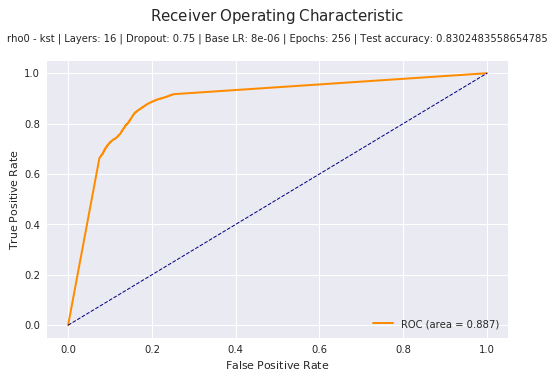

Inference complete. Duration: 4.58042 s


In [7]:
ckpt = tf.train.get_checkpoint_state(directories.checkpoints)
vDNN = vanillaDNN(config, training = False)
network_output = vDNN.predict(ckpt)

np.save(os.path.join(directories.checkpoints, '{}_{}_y_pred.npy'.format(config.channel, config.mode)), network_output)
np.save(os.path.join(directories.checkpoints, '{}_{}_y_test.npy'.format(config.channel, config.mode)), df_y_test.values)